we will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight, and consulting julia about new layout trials.

<br>
we have tree sub tasks involved to get the insights

* **Select control stores :** A control store is a store which has the most similar performance to the trial store over the period of time. we can use the performance of this store as the base performance for the trial store over the period of trial and can make discisions weather the new layout leads in the increament of the sales and number of costumers or not.




* **Assessment of the trial :** comparision of the performance of the trial store with the base performace (control store's performance) .


* **Collate findings**


let's import the modules and load the dataset provided

In [1]:

# Data analysis and wragling
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno

# Statistics
from statistics import stdev
from scipy.stats import t

# Dates
import matplotlib.dates as mdates

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("../Data/QVI_data.csv")
print(data.shape)
data.head()

(264834, 12)


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


now let's look the basic stastics of the data and inconsistencies such as missing values and incorrect data formats

<AxesSubplot:>

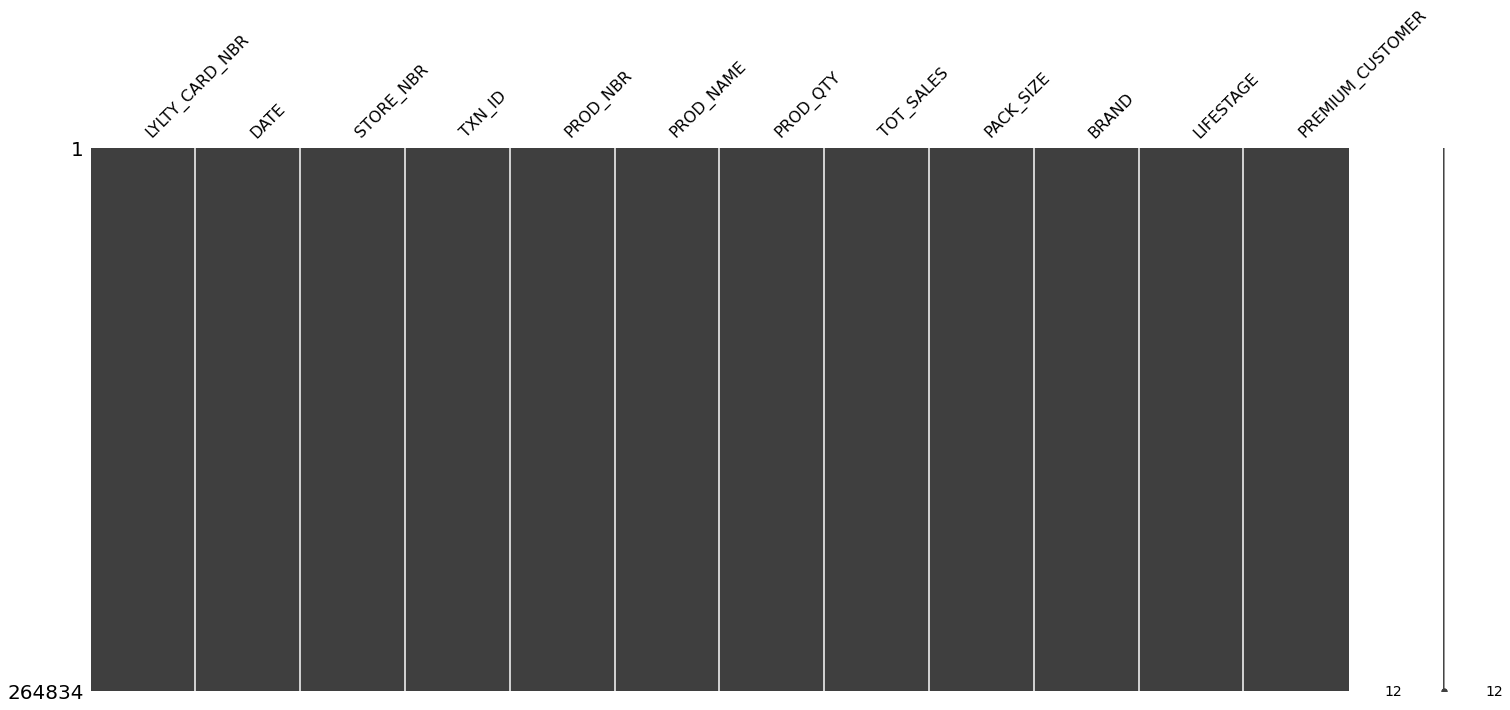

In [3]:
# Check for null 

missingno.matrix(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
data.describe()

,LYLTY_CARD_NBR,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,2.648340e+05,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000
mean,1.355488e+05,135.079423,1.351576e+05,56.583554,1.905813,7.299346,182.425512
std,8.057990e+04,76.784063,7.813292e+04,32.826444,0.343436,2.527241,64.325148
min,1.000000e+03,1.000000,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,7.002100e+04,70.000000,6.760050e+04,28.000000,2.000000,5.400000,150.000000
50%,1.303570e+05,130.000000,1.351365e+05,56.000000,2.000000,7.400000,170.000000
75%,2.030940e+05,203.000000,2.026998e+05,85.000000,2.000000,9.200000,175.000000
max,2.373711e+06,272.000000,2.415841e+06,114.000000,5.000000,29.500000,380.000000


In [6]:
# Create 'YEARMONTH' feature

data['YEARMONTH'] = [''.join(x.split('-')[0:2]) for x in data.DATE]
data['YEARMONTH'] = pd.to_numeric(data['YEARMONTH'])
data['YEARMONTH'].head()

0    201810
1    201809
2    201903
3    201903
4    201811
Name: YEARMONTH, dtype: int64

# Select control stores
**The client has selected stores 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.**

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:


* Monthly overall sales revenue

* Monthly number of customers

* Monthly number of transactions per customer


Let's first create the metrics of interest and filter out stores that are present throughout the pre-trial period.


our metric of interest would be 
* Total sales
* Number of customers,
* Average transactions per customer
* Average chips per customer
* Average price per unit

let's write a function which calculates the meric for us

In [7]:
def metrics():
    store_month = data.groupby(['STORE_NBR','YEARMONTH'])
    totsales = store_month['TOT_SALES'].sum()
    no_cust = store_month['LYLTY_CARD_NBR'].nunique()
    trans_per_cust = store_month.size()/no_cust
    avg_chips_per_cust = store_month['PROD_QTY'].sum()/no_cust
    avg_chips_price = totsales/store_month['PROD_QTY'].sum()
    
    agg = [totsales,no_cust,trans_per_cust,avg_chips_per_cust,avg_chips_price]
    met = pd.concat(agg,axis=1)
    met.columns =  ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return met

In [8]:
measureOverTime = metrics().reset_index()

In [9]:
measureOverTime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YEARMONTH        3169 non-null   int64  
 2   TOT_SALES        3169 non-null   float64
 3   nCustomers       3169 non-null   int64  
 4   nTxnPerCust      3169 non-null   float64
 5   nChipsPerTxn     3169 non-null   float64
 6   avgPricePerUnit  3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


In [10]:
measureOverTime.head()

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


as our client told us to exlude the store that aren't even active for all 12 months of an year , let's figure out thode stores and drop them

In [11]:
# Which stores do not have full observation i.e. have months where there is no transaction for chips

a = pd.pivot_table(data, index = 'STORE_NBR', columns = 'YEARMONTH', values = 'TXN_ID', aggfunc = 'count')
a

YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [12]:
a.isnull().sum()


YEARMONTH
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

<AxesSubplot:>

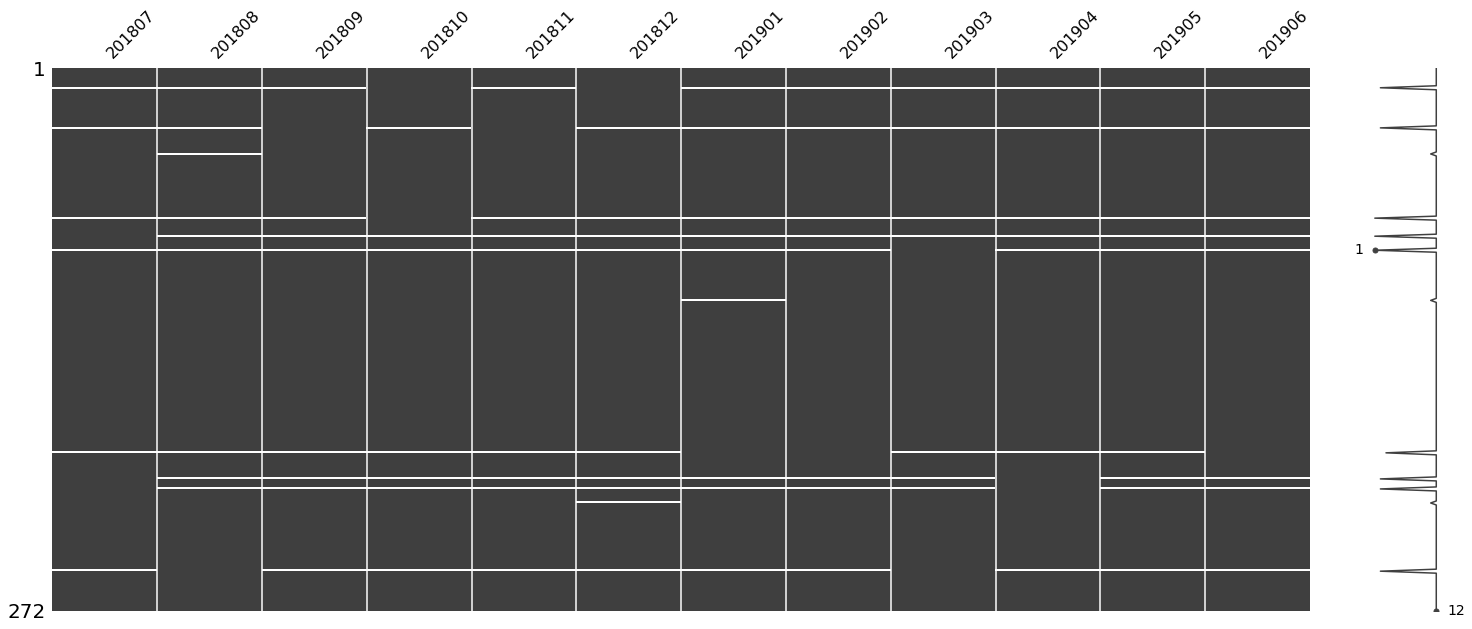

In [13]:
# Let's visualise the null values

missingno.matrix(a)

In [14]:

# Store numbers that do not have full observation periods

null_store = a[a.isnull().any(axis=1)].index.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [15]:
len(null_store)

12

we can see that there are total `12` stores i.e.`[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]` , which are not active for full year so we will be droping the records for these stores

In [16]:
# Drop 'null_store' from 'measureOverTime' dataframe

measureOverTime = measureOverTime[~measureOverTime['STORE_NBR'].isin(null_store)]
len(measureOverTime)

3120

now we need to filter preTrial data from our measure over time dataset so that we can compare the performance of each trial store with the reast of the store(`non-trial` ones) and can determine then can detemine the control store for each trail store 

In [17]:
# Create new dataframe 'preTrialMeasures' 
# Filter to pre-trial period i.e. before 201902

preTrialMeasures = measureOverTime.loc[measureOverTime['YEARMONTH'] < 201902, :]
len(preTrialMeasures)

1820

In [18]:
preTrialMeasures.head()

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


now we will write two functions one is `calculateCorrelation` and the another one is `calculateMagnitudeDistance`.

* **`calculateCorrelation` :** will be used to calculate the correlation between the two store (trial store and the potential control store) over the given metric such as `TOT_SALES` and `nCustomers` .



* **`calculateMagnitudeDistance` :** will be used to calculate the standardised magnitude distance between the selected matric for trial store and control store .


In [19]:
# creating a function which calculates the correlation between trial store and other stores based on a single metric

def calculateCorrelation(inputTable ,metric,trial_store):
    out = pd.DataFrame({'TrialStore':[],
                       'ControlStore':[],
                       'Correlation':[]
                       })
    trialStoreMetric = inputTable.loc[inputTable['STORE_NBR']==trial_store,metric]
    trialStoreMetric.reset_index(drop=True,inplace=True)
    storeNumbers = inputTable[~inputTable['STORE_NBR'].isin([77,86,88])]['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR']==i,metric]
        b.reset_index(drop =True,inplace=True)
        out = out.append({'TrialStore': trial_store, 'ControlStore': i, 'Correlation': b.corr(trialStoreMetric)}, ignore_index = True)
    return out

In [20]:
# Creating another function which calculates a standardised magnitude difference
def calculateMagnitudeDistance(inputTable, metric, trial_store):
    out = pd.DataFrame({
        'TrialStore':[],
        'ControlStore':[],
        'Magnitude':[]
    })
    a = inputTable.loc[inputTable['STORE_NBR']==trial_store,metric]
    a.reset_index(drop=True,inplace=True)
    storeNumbers = inputTable[~inputTable['STORE_NBR'].isin([77,86,88])]['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR']==i,metric]
        b.reset_index(drop=True,inplace=True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        out=out.append({'TrialStore': trial_store, 'ControlStore': i, 'Magnitude': d}, ignore_index = True)
    return out

now we are going to write a function which will help us determine the control store for a trial store , actually it will give us the final score for each potential control store with respect to the control store .
will name this as `calcScore` 

* this will take just trial score number as input
* will calculate the tot sales based correlation using above created function
* will calculate the sales based magnitude using the function above
* will take the weighted average of above 2 scores
* will repeat above three steps for monthly number of customers 
* finnaly will calculate the weighted avg of score for totsales and score for ncustomers

In [21]:
def calcScore(trial_store):
    corr_nSales = calculateCorrelation(preTrialMeasures,'TOT_SALES',trial_store)
    corr_nCustomers = calculateCorrelation(preTrialMeasures,'nCustomers' , trial_store)
    magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures,'TOT_SALES',trial_store)
    magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures,'nCustomers',trial_store)
    
    # concatenate the score together for nSales
    score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)
    corr_weight = 0.5
    score_nSales['scoreNSales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
    """
    
    now let's repeat the same steps for ncustomers """
    score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)
    score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
    
    # Index both 'score_nSales' and 'score_nCustomers' dataframe

    score_nSales.set_index(['TrialStore', 'ControlStore'], inplace = True)
    score_nCustomers.set_index(['TrialStore', 'ControlStore'], inplace = True)
    
    score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
    score_Control
    score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
    output = pd.DataFrame()
    output = score_Control;
    output['sales_corr'] = score_nSales['Correlation']
    output['sales_magnitude'] = score_nSales['Magnitude']
    output['Sales_Score'] = score_nSales['scoreNSales']
    output['nCustomers_corr'] = score_nCustomers['Correlation']
    output['Correlation_mag'] = score_nCustomers['Magnitude']
    output['nCustomers_Score']  = score_nCustomers['scoreNCust']
    output.sort_values(by = 'finalControlScore', ascending = False,inplace=True)
    
    return output.style.set_properties(**{'background-color': 'green'}, subset=['finalControlScore'])

`label_stores` function as the name suggests will be used to catogerises the stores in `trail store`, `control store ` and `other stores`.

In [22]:
def label_stores(trial_store,control_store):
    out = preTrialMeasures.copy()
    out['store_type'] = 'Other Stores'
    out.loc[out.STORE_NBR==trial_store , "store_type"]='Trial Store'
    out.loc[out.STORE_NBR==control_store , "store_type"]='Control Store'
    return out

now let's write a function which uses the result of above labeling function and return a table of metric ,'`totsales` or `ncustomers` , for each transaction month , mean for others type stores

In [23]:
def plotable_table(metric,trial_store,control_store):
    pastdata = label_stores(trial_store,control_store)
    # currently "YEARMONTH" is an int64 type so we need to turn it into datetime to be able to plot
    # let's create another columns called "TransactionMonth"
    pastdata['TransactionMonth'] = pd.to_datetime(pastdata['YEARMONTH'].astype(str),format='%Y%m')
    
    # now create metric visulisation table for control store 
    controlTable = pastdata.loc[pastdata['store_type']=='Control Store',['TransactionMonth',metric]]
    controlTable.set_index('TransactionMonth', inplace =True)
    controlTable.rename(columns={metric:'Control Store'},inplace=True)
    # create the same visualisation table for trial store
    trialTable = pastdata.loc[pastdata['store_type']=='Trial Store', ['TransactionMonth' ,metric]]
    trialTable.set_index('TransactionMonth',inplace=True)
    trialTable.rename(columns={metric:'Trial Store'},inplace=True)
    # let's do the same for 'other stores' make sure to use mean this time since we are having more than one store 
    # in a single TransactionMonth so we have to take the mean of them
    
    otherTable = pastdata.loc[pastdata['store_type']=='Other Stores' , ['TransactionMonth' ,metric]]
    otherTable = pd.DataFrame(otherTable.groupby('TransactionMonth')[metric].mean())
    otherTable.rename(columns={metric:'Other Stores'}, inplace =True)
    
    combineTable = pd.concat([controlTable,trialTable,otherTable], axis=1)
    return combineTable

# Estimating control store 
so far we have created all the necessary functions to decide the control store for each of the trail store based upon various features . so let's dive in


In order to determine control store we will need statsa from the the functions

* **calcScore** this will use correlation and magnitude function and will give us the final score stats for given trial store
* **plotable_table** will give us a table that can be plotted to justify the control store

### Selecting Control Store for trial sotre 77


In [24]:
score77 = calcScore(77)
score77

`score77` table shows us that the store with the most similar performance to the trial store `77` is store `233` so it's the most suitable control store for this trial store .

Let's visualize it with different metrices
    
    * TOT_SALES
    * nCustomers

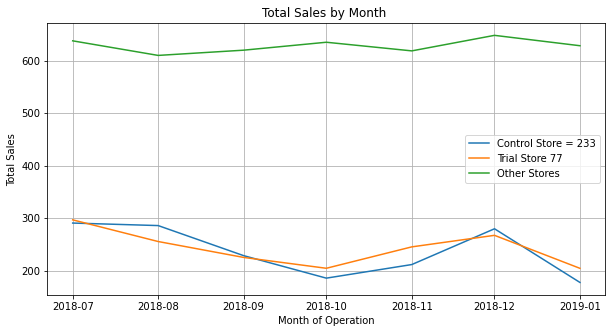

In [25]:

# Plot total sales by month for all 3 types of stores
combineSalesPlot = plotable_table('TOT_SALES',77 , 233)
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month ')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store = 233', 'Trial Store 77', 'Other Stores'], loc = 5);
plt.grid(True);

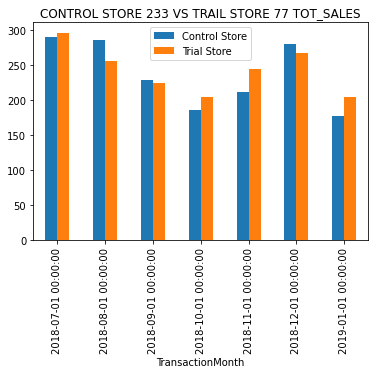

In [26]:
combineSalesPlot[['Control Store','Trial Store']].plot.bar().set_title("CONTROL STORE 233 VS TRAIL STORE 77 TOT_SALES");


Now let's visualise for nCustormers feature 

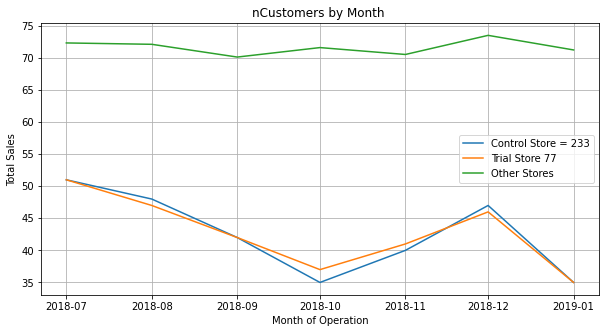

In [27]:

# Plot nCustomers by month for all 3 types of stores
combinenCustomersPlot = plotable_table('nCustomers',77 , 233)
plt.figure(figsize = (10, 5))
plt.plot(combinenCustomersPlot)
plt.title('nCustomers by Month ')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store = 233', 'Trial Store 77', 'Other Stores'], loc = 5);
plt.grid(True);

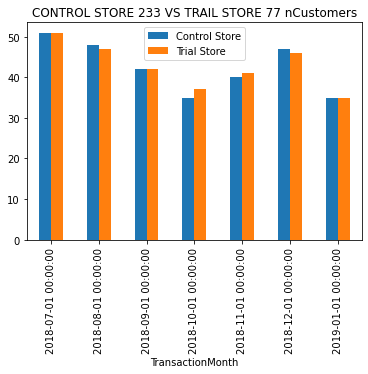

In [28]:
combinenCustomersPlot[['Control Store','Trial Store']].plot.bar().set_title("CONTROL STORE 233 VS TRAIL STORE 77 nCustomers");


above stats score and  all the plots for nCustomers and TOT_SALES indicates that the control store 233 is very much similar to trial store 77 in terms of performance .

**store 233 is the Control store for trail store 77**


### Deciding control store for  trial store 86

In [29]:
score86 = calcScore(86)
score86

`score86` table shows us that the store with the most similar performance to the trial store `86` is store `155` so it's the most suitable control store for this trial store .

Let's visualize it with different metrices
    
    * TOT_SALES
    * nCustomers

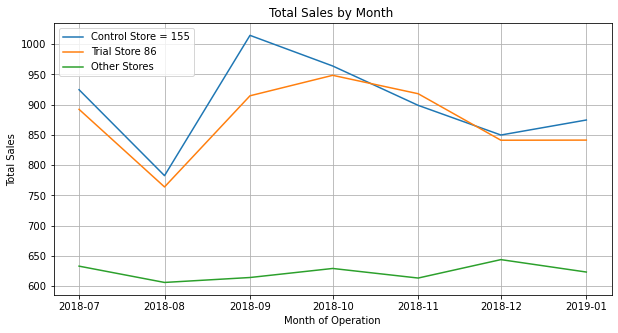

In [30]:

# Plot total sales by month for all 3 types of stores
combineSalesPlot = plotable_table('TOT_SALES',86, 155)
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month ')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store = 155', 'Trial Store 86', 'Other Stores'], loc = 2);
plt.grid(True);

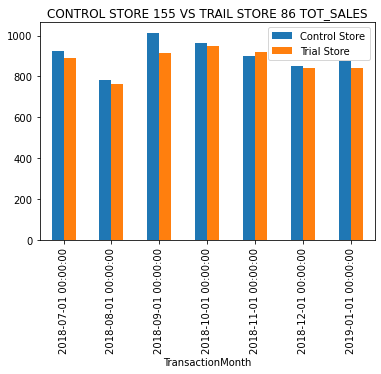

In [31]:
combineSalesPlot[['Control Store','Trial Store']].plot.bar().set_title("CONTROL STORE 155 VS TRAIL STORE 86 TOT_SALES");


Now let's visualise for nCustormers feature 

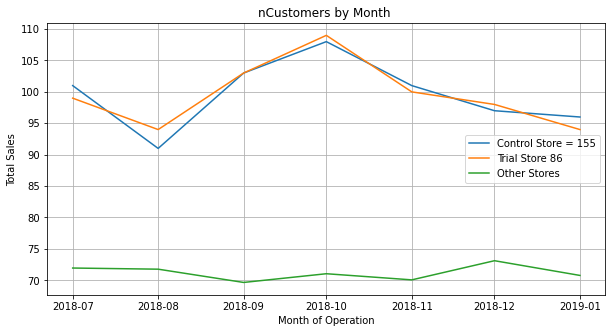

In [32]:
# Plot nCustomers by month for all 3 types of stores
combinenCustomersPlot = plotable_table('nCustomers',86 , 155)
plt.figure(figsize = (10, 5))
plt.plot(combinenCustomersPlot)
plt.title('nCustomers by Month ')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store = 155', 'Trial Store 86', 'Other Stores'], loc = 5);
plt.grid(True);

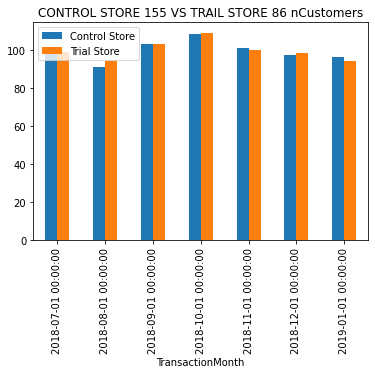

In [33]:
combinenCustomersPlot[['Control Store','Trial Store']].plot.bar().set_title("CONTROL STORE 155 VS TRAIL STORE 86 nCustomers");


above stats score and  all the plots for nCustomers and TOT_SALES indicates that the control store 155 is very much similar to trial store 86 in terms of performance .

**store 155 is the Control store for trail store 86**


### Deciding control store for  trial store 88

In [34]:
score88 = calcScore(88)
score88

`score88` table shows us that the store with the most similar performance to the trial store `88` is store `178` so it's the most suitable control store for this trial store .

Let's visualize it with different metrices
    
    * TOT_SALES
    * nCustomers
    
we will find something different 

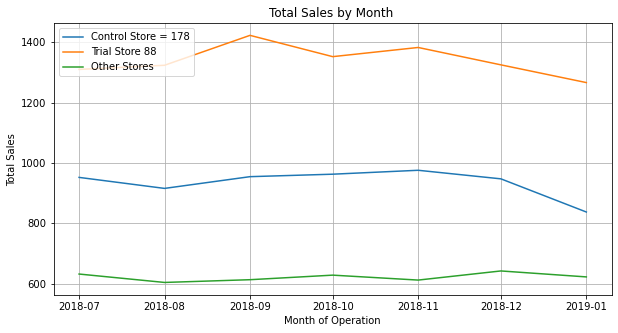

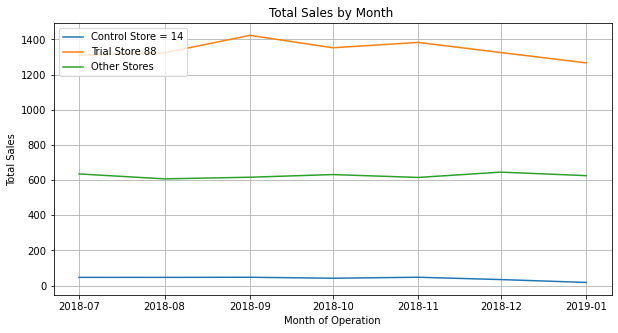

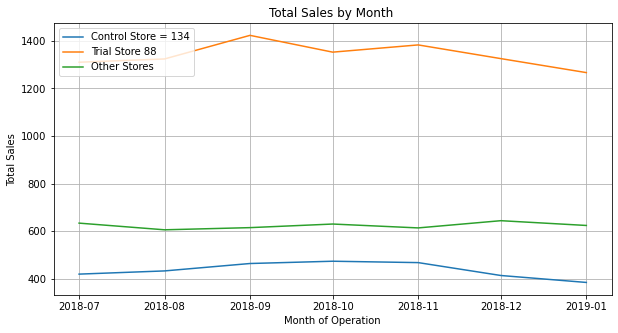

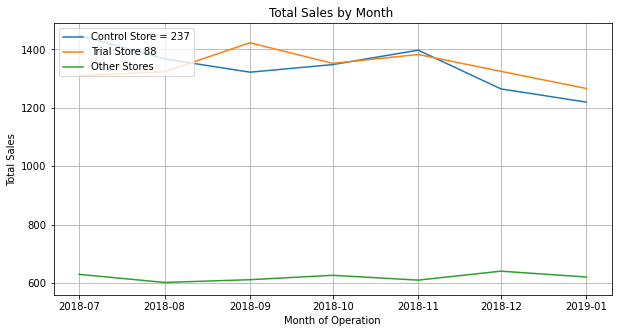

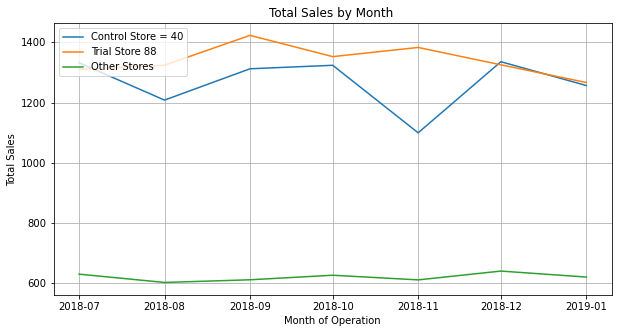

In [35]:
#let's plot for 5 score values
x = [178,14,134,237,40]
for i in x:
    
    # Plot total sales by month for all 3 types of stores
    combineSalesPlot = plotable_table('TOT_SALES',88, i)
    plt.figure(figsize = (10, 5))
    plt.plot(combineSalesPlot)
    plt.title('Total Sales by Month ')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Sales')
    plt.legend(['Control Store = '+str(i), 'Trial Store 88', 'Other Stores'], loc = 2);
    plt.grid(True);

well , we can see that control store 237 performs really close to the trial store 88 , let's visualise it further considering 237 the control store for trial store 88

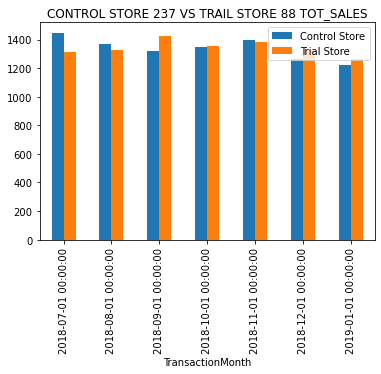

In [36]:
combineSalesPlot = plotable_table('TOT_SALES',88,237)
combineSalesPlot[['Control Store','Trial Store']].plot.bar().set_title("CONTROL STORE 237 VS TRAIL STORE 88 TOT_SALES");


visualise this in terms of monthly costumers

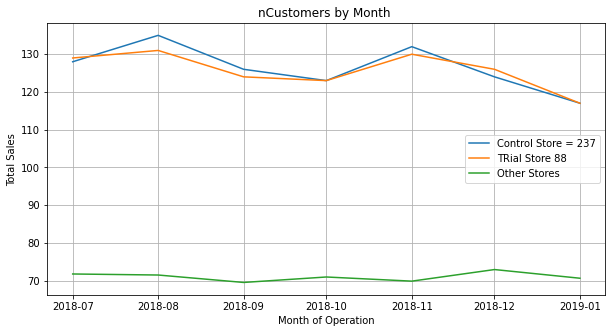

In [37]:
# Plot nCustomers by month for all 3 types of stores
combinenCustomersPlot = plotable_table('nCustomers',88 , 237)
plt.figure(figsize = (10, 5))
plt.plot(combinenCustomersPlot)
plt.title('nCustomers by Month ')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store = 237', 'TRial Store 88', 'Other Stores'], loc = 5);
plt.grid(True);

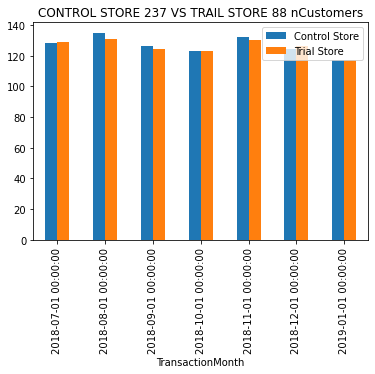

In [38]:
combinenCustomersPlot[['Control Store','Trial Store']].plot.bar().set_title("CONTROL STORE 237 VS TRAIL STORE 88 nCustomers");


haaah above comparision plots show that trial store 88 is much closer to the control store 237 

so 

<table>
    <thead>
        <th>Trial Store</th>
        <th>Control Store</th>
    </thead>
    <tr>
        <td>77</td>
        <td>233</td>
    </tr>
    <tr>
        <td>86</td>
        <td>155</td>
    </tr>
    <tr>
        <td>88</td>
        <td>237</td>
    </tr>
</table>

Now we need to dive in assement part that is to measure the impact of experimentation on trial store during trial period.

`scaleControl` function scalesup the control store's performance by the ratio of `trailsum/controlsum`

In [39]:
def scaleControl(trial_store, control_store,metric):
    base = label_stores(trial_store,control_store)
    base['TransactionMonth'] = pd.to_datetime(base['YEARMONTH'].astype(str),format='%Y%m')
    # First we need to work out a scaling factor to applied to the control store
    # We compute this by dividing sum of 'metric' for trial store by sum of 'metric' for control store
    # Let's call this variable 'scalingFactor'
    
    trial_sum = base.loc[base['store_type'] == 'Trial Store' , metric].sum()
    control_sum = base.loc[base['store_type'] == 'Control Store', metric].sum()
    scalingFactor = trial_sum / control_sum
    # now we need to scale the metric for full time by this factor
    out = measureOverTime.copy()
    # select only control store data
    out = out.loc[out['STORE_NBR']==control_store]
    x = "ScaleControl"+str(metric)
    out[x] = out[metric]*scalingFactor
    return out

`percentDiff` function takes trial store , control store and the comparision metric and returns the percentage difference in the trial store and control store over that particular metric 

In [40]:
def percentDiff(trial_store,control_store,metric):
    base = scaleControl(trial_store,control_store,metric)
    f = "ScaleControl"+str(metric)
    percentDiff = base[['YEARMONTH',f]]
    percentDiff.reset_index(drop=True,inplace=True)
    # now let's get the metric data for trial store
    d = "trial"+str(metric)
    x = measureOverTime.loc[measureOverTime['STORE_NBR']==trial_store,metric]
    x.reset_index(drop=True,inplace=True)
    
    percentDiff = pd.concat([percentDiff,x],axis=1)
    percentDiff.rename(columns={metric:d},inplace=True)
    
    # Calculate percentage difference and put it in a new column

    percentDiff['percentageDiff'] = abs(percentDiff[f] - percentDiff[d]) / percentDiff[f]
    return percentDiff
    

In [41]:
def calcstDev(trial_store,control_store,metric):
    df =percentDiff(trial_store,control_store,metric)
    stdDev = stdev(df.loc[df['YEARMONTH'] < 201902, 'percentageDiff'])
    return stdDev

`calcTvalue` function calculates t value for each combo of trial store control store and comparison metric .

since we are having 8 months pretial data so degree of freedom goes 7 (n-1) and if we calculate the t value for 95% confidance interval we get value around 1.89 

so for a combination of feature we get t value significantley higher than 1.89 means there's and uplift during that trial period.considering null hypothesis to be no change during trial period

In [42]:
def calcTvalue(trial_store,control_store,metric):
    stdDev = calcstDev(trial_store,control_store,metric)
    df = percentDiff(trial_store,control_store,metric)
    df['tValue'] = (df['percentageDiff']-0)/stdDev
    return df

In [43]:
def cfInterval(trial_store,control_store,metric):
    controlScale = scaleControl(trial_store,control_store,metric)
    stdDev = calcstDev(trial_store,control_store,metric)
    # Add a new column 'TransactionMonth' to 'scaledControlSales'

    controlScale['TransactionMonth'] = pd.to_datetime(controlScale['YEARMONTH'].astype(str), format = '%Y%m')
    
    # Time for some visualisation
    # First we need to create the appropriate dataframe
    xcontrol ='Control '+metric.split('_')[-1]
    xc ="ScaleControl"+str(metric)
    controlScale = controlScale.loc[:, ['TransactionMonth',xc ]]
    controlScale.set_index('TransactionMonth', inplace = True)
    controlScale.rename(columns = {xc: xcontrol}, inplace = True)
    # now let's use the measureovertime dataframe and get trial data
    trialScale = measureOverTime.copy()
    trialScale['TransactionMonth'] = pd.to_datetime(trialScale['YEARMONTH'].astype(str),format='%Y%m')
    # Extract  trial store from trialScale

    trialScale = trialScale.loc[trialScale['STORE_NBR'] == trial_store, ['TransactionMonth', metric]]
    trialScale.set_index('TransactionMonth', inplace = True)
    trialScale.rename(columns = {metric: 'trial '+metric.split('_')[-1]}, inplace = True)
    
    # now let's make 5% and 95% confidance interval for control store data
    
    controlScale['Control 5% Confidence Interval'] = controlScale[xcontrol] * (1 - stdDev*2)
    controlScale['Control 95% Confidence Interval'] = controlScale[xcontrol] * (1 + stdDev*2)
    
    # Merge the two dataframes together 'controlSales' and 'trialSales'

    combine = pd.merge(controlScale, trialScale, left_index = True, right_index = True)
    return combine
    

## Assessment of trial for trial strore 77
The trial period goes from the start of February 2019 to end of April 2019. We now want to see if there has been an uplift in overall chip sales.

In [44]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'nCustomers' for trial store by sum of 'totSales' for control store
# Let's call this variable 'scalingFactorSales'
scaledControlSales = scaleControl(77,233,'TOT_SALES')
scaledControlSales

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaleControlTOT_SALES
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,216.597421
2704,233,201812,279.8,47,1.063830,1.595745,3.730667,286.408121
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,181.692071
2706,233,201902,244.0,45,1.044444,1.555556,3.485714,249.762622
2707,233,201903,199.1,40,1.025000,1.475000,3.374576,203.802205
2708,233,201904,158.6,30,1.100000,1.533333,3.447826,162.345704


In [45]:
# Calculate percentage difference
percentageDiffSales = percentDiff(77,233,'TOT_SALES')
percentageDiffSales

,YEARMONTH,ScaleControlTOT_SALES,trialTOT_SALES,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


In [46]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7
dof = 7
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

1.8945786050613054

In [47]:
percentageDiffSales = calcTvalue(77,233,'TOT_SALES')
percentageDiffSales

,YEARMONTH,ScaleControlTOT_SALES,trialTOT_SALES,percentageDiff,tValue
0,201807,297.565550,296.8,0.002573,0.051515
1,201808,292.652187,255.5,0.126950,2.542011
2,201809,233.998916,225.2,0.037602,0.752940
3,201810,190.085733,204.5,0.075830,1.518406
4,201811,216.597421,245.3,0.132516,2.653459
5,201812,286.408121,267.3,0.066716,1.335911
6,201901,181.692071,204.4,0.124980,2.502571
7,201902,249.762622,235.0,0.059107,1.183534
8,201903,203.802205,278.5,0.366521,7.339116
9,201904,162.345704,263.5,0.623080,12.476373


 We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.
 
 Now let's we have reached to a conslusion that accordig to the comparision metric `TOT_SALES` there's and uplift in march and april , wont it be great if we can visualize this thing.
 
 let's make 5% and 95% confidance interval and plot a comparison graph

In [48]:
combineSales = cfInterval(77,233,'TOT_SALES')
combineSales

,Control SALES,Control 5% Confidence Interval,Control 95% Confidence Interval,trial SALES
TransactionMonth,,,,
2018-07-01,297.565550,267.844249,327.286851,296.8
2018-08-01,292.652187,263.421640,321.882734,255.5
2018-09-01,233.998916,210.626747,257.371084,225.2
2018-10-01,190.085733,171.099680,209.071786,204.5
2018-11-01,216.597421,194.963341,238.231502,245.3
2018-12-01,286.408121,257.801241,315.015001,267.3
2019-01-01,181.692071,163.544390,199.839753,204.4
2019-02-01,249.762622,224.815950,274.709294,235.0
2019-03-01,203.802205,183.446130,224.158280,278.5


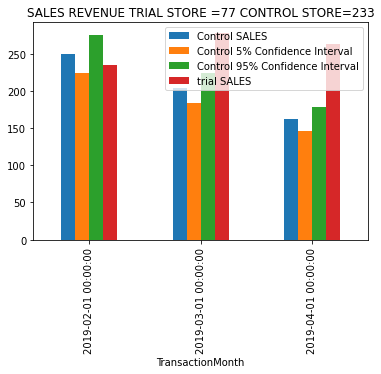

In [49]:
combineSales.iloc[7:10].plot.bar().set_title("SALES REVENUE TRIAL STORE =77 CONTROL STORE=233");

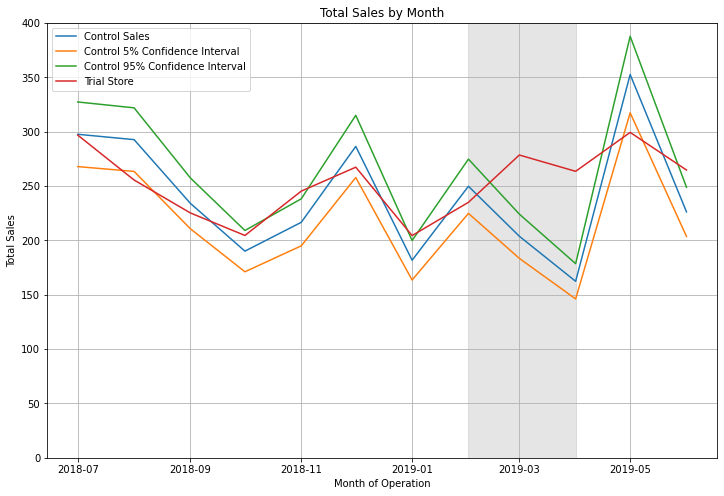

In [50]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

Let's find the same stats for nCustomers metric for trial store 77

In [51]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'nCustomers' for trial store by sum of 'nCustomers' for control store
# Let's call this variable 'scalingFactornCustomers'
scaledControlnCustomers = scaleControl(77,233,'nCustomers')
scaledControlnCustomers

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaleControlnCustomers
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,51.171141
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,48.161074
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,42.140940
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,35.117450
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,40.134228
2704,233,201812,279.8,47,1.063830,1.595745,3.730667,47.157718
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,35.117450
2706,233,201902,244.0,45,1.044444,1.555556,3.485714,45.151007
2707,233,201903,199.1,40,1.025000,1.475000,3.374576,40.134228
2708,233,201904,158.6,30,1.100000,1.533333,3.447826,30.100671


In [52]:
# Calculate percentage difference
percentageDiffnCustomers = percentDiff(77,233,'nCustomers')
percentageDiffnCustomers

,YEARMONTH,ScaleControlnCustomers,trialnCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


In [53]:
percentageDiffnCustomers = calcTvalue(77,233,'nCustomers')
percentageDiffnCustomers

,YEARMONTH,ScaleControlnCustomers,trialnCustomers,percentageDiff,tValue
0,201807,51.171141,51,0.003344,0.183352
1,201808,48.161074,47,0.024108,1.321664
2,201809,42.140940,42,0.003344,0.183352
3,201810,35.117450,37,0.053607,2.938874
4,201811,40.134228,41,0.021572,1.182622
5,201812,47.157718,46,0.024550,1.345883
6,201901,35.117450,35,0.003344,0.183352
7,201902,45.151007,45,0.003344,0.183352
8,201903,40.134228,50,0.245819,13.476388
9,201904,30.100671,47,0.561427,30.778725


 We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.
 
 Now let's we have reached to a conslusion that accordig to the comparision metric `nCustomers	` there's and uplift in march and april , wont it be great if we can visualize this thing.
 
 let's make 5% and 95% confidance interval and plot a comparison graph

In [54]:
combinenCustomers = cfInterval(77,233,'nCustomers')
combinenCustomers

,Control nCustomers,Control 5% Confidence Interval,Control 95% Confidence Interval,trial nCustomers
TransactionMonth,,,,
2018-07-01,51.171141,49.304341,53.037941,51
2018-08-01,48.161074,46.404086,49.918062,47
2018-09-01,42.140940,40.603575,43.678304,42
2018-10-01,35.117450,33.836313,36.398587,37
2018-11-01,40.134228,38.670071,41.598385,41
2018-12-01,47.157718,45.437334,48.878102,46
2019-01-01,35.117450,33.836313,36.398587,35
2019-02-01,45.151007,43.503830,46.798183,45
2019-03-01,40.134228,38.670071,41.598385,50


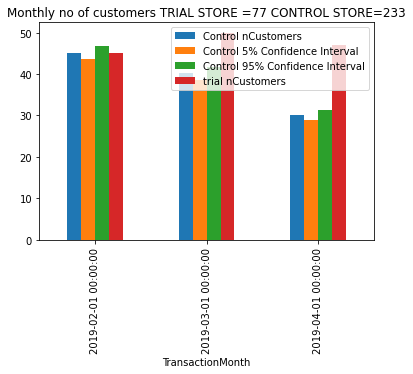

In [55]:
combinenCustomers.iloc[7:10].plot.bar().set_title("Monthly no of customers TRIAL STORE =77 CONTROL STORE=233");

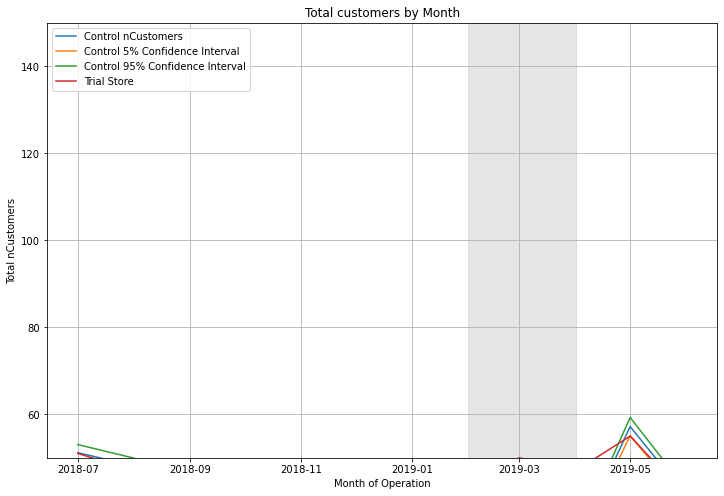

In [56]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combinenCustomers)

# Set graph title and axis title
plt.title('Total customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total nCustomers')

# Set legend
plt.legend(['Control nCustomers', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((50, 150))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()


The results show that the trial in store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in the two of the 3 trial months, Indicating uplift.

Now we need to repeat same steps for trial store 86 and 88 

## Assessment of trial for trial strore 86

In [57]:
scaledControlSales = scaleControl(86,155,'TOT_SALES')
scaledControlSales

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaleControlTOT_SALES
1793,155,201807,924.60,101,1.237624,2.475248,3.698400,896.922236
1794,155,201808,782.70,91,1.318681,2.516484,3.417904,759.269991
1795,155,201809,1014.40,103,1.407767,2.815534,3.497931,984.034086
1796,155,201810,963.80,108,1.259259,2.518519,3.543382,934.948790
1797,155,201811,898.80,101,1.336634,2.673267,3.328889,871.894555
1798,155,201812,849.80,97,1.247423,2.494845,3.511570,824.361363
1799,155,201901,874.60,96,1.312500,2.625000,3.470635,848.418979
1800,155,201902,891.20,95,1.336842,2.673684,3.508661,864.522060
1801,155,201903,804.40,94,1.276596,2.553191,3.351667,780.320405
1802,155,201904,844.60,99,1.222222,2.444444,3.490083,819.317024


In [58]:
# Calculate percentage difference
percentageDiffSales = percentDiff(86,155,'TOT_SALES')
percentageDiffSales

,YEARMONTH,ScaleControlTOT_SALES,trialTOT_SALES,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


In [59]:
percentageDiffSales = calcTvalue(86,155,'TOT_SALES')
percentageDiffSales

,YEARMONTH,ScaleControlTOT_SALES,trialTOT_SALES,percentageDiff,tValue
0,201807,896.922236,892.20,0.005265,0.203799
1,201808,759.269991,764.05,0.006296,0.243692
2,201809,984.034086,914.60,0.070561,2.731315
3,201810,934.948790,948.40,0.014387,0.556907
4,201811,871.894555,918.00,0.052880,2.046904
5,201812,824.361363,841.20,0.020426,0.790676
6,201901,848.418979,841.40,0.008273,0.320238
7,201902,864.522060,913.20,0.056306,2.179542
8,201903,780.320405,1026.80,0.315870,12.226922
9,201904,819.317024,848.20,0.035253,1.364580


 We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March.
 
 Now let's we have reached to a conslusion that accordig to the comparision metric `TOT_SALES` there's and uplift in march and april , wont it be great if we can visualize this thing.
 
 let's make 5% and 95% confidance interval and plot a comparison graph

In [60]:
combineSales = cfInterval(86,155,'TOT_SALES')
combineSales

,Control SALES,Control 5% Confidence Interval,Control 95% Confidence Interval,trial SALES
TransactionMonth,,,,
2018-07-01,896.922236,850.580142,943.264329,892.20
2018-08-01,759.269991,720.040101,798.499882,764.05
2018-09-01,984.034086,933.191106,1034.877067,914.60
2018-10-01,934.948790,886.641944,983.255636,948.40
2018-11-01,871.894555,826.845589,916.943521,918.00
2018-12-01,824.361363,781.768338,866.954388,841.20
2019-01-01,848.418979,804.582947,892.255010,841.40
2019-02-01,864.522060,819.854016,909.190104,913.20
2019-03-01,780.320405,740.002884,820.637926,1026.80


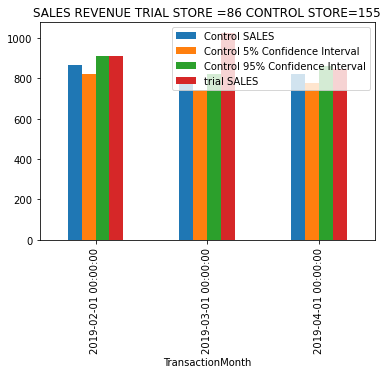

In [61]:
combineSales.iloc[7:10].plot.bar().set_title("SALES REVENUE TRIAL STORE =86 CONTROL STORE=155");

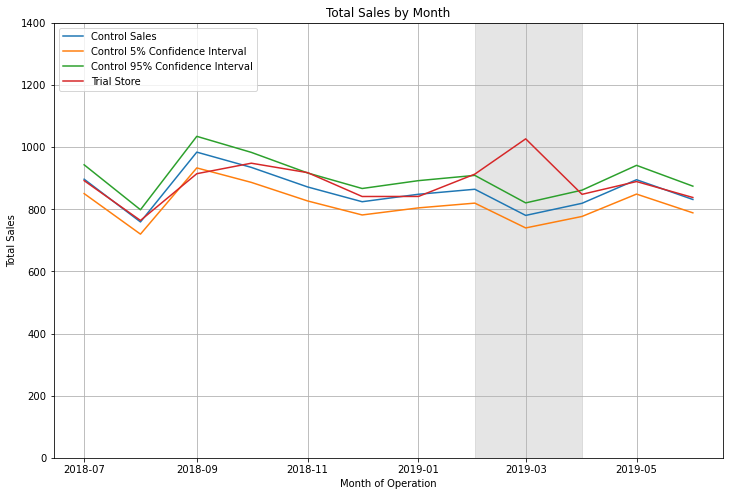

In [62]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0,1400 ))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period. The trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.



let's check for nCustomers now

In [63]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'nCustomers' for trial store by sum of 'nCustomers' for control store
# Let's call this variable 'scalingFactornCustomers'
scaledControlnCustomers = scaleControl(86,155,'nCustomers')
scaledControlnCustomers

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaleControlnCustomers
1793,155,201807,924.60,101,1.237624,2.475248,3.698400,101.0
1794,155,201808,782.70,91,1.318681,2.516484,3.417904,91.0
1795,155,201809,1014.40,103,1.407767,2.815534,3.497931,103.0
1796,155,201810,963.80,108,1.259259,2.518519,3.543382,108.0
1797,155,201811,898.80,101,1.336634,2.673267,3.328889,101.0
1798,155,201812,849.80,97,1.247423,2.494845,3.511570,97.0
1799,155,201901,874.60,96,1.312500,2.625000,3.470635,96.0
1800,155,201902,891.20,95,1.336842,2.673684,3.508661,95.0
1801,155,201903,804.40,94,1.276596,2.553191,3.351667,94.0
1802,155,201904,844.60,99,1.222222,2.444444,3.490083,99.0


In [64]:
# Calculate percentage difference
percentageDiffnCustomers = percentDiff(86,155,'nCustomers')
percentageDiffnCustomers

,YEARMONTH,ScaleControlnCustomers,trialnCustomers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901
5,201812,97.0,98,0.010309
6,201901,96.0,94,0.020833
7,201902,95.0,107,0.126316
8,201903,94.0,115,0.223404
9,201904,99.0,105,0.060606


In [65]:
percentageDiffnCustomers = calcTvalue(86,155,'nCustomers')
percentageDiffnCustomers

,YEARMONTH,ScaleControlnCustomers,trialnCustomers,percentageDiff,tValue
0,201807,101.0,99,0.019802,1.852826
1,201808,91.0,94,0.032967,3.084651
2,201809,103.0,103,0.000000,0.000000
3,201810,108.0,109,0.009259,0.866368
4,201811,101.0,100,0.009901,0.926413
5,201812,97.0,98,0.010309,0.964616
6,201901,96.0,94,0.020833,1.949328
7,201902,95.0,107,0.126316,11.819082
8,201903,94.0,115,0.223404,20.903430
9,201904,99.0,105,0.060606,5.670772


 We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.
 
 Now let's we have reached to a conslusion that accordig to the comparision metric `nCustomers	` there's and uplift in march and april , wont it be great if we can visualize this thing.
 
 let's make 5% and 95% confidance interval and plot a comparison graph

In [66]:
combinenCustomers = cfInterval(86,155,'nCustomers')
combinenCustomers

,Control nCustomers,Control 5% Confidence Interval,Control 95% Confidence Interval,trial nCustomers
TransactionMonth,,,,
2018-07-01,101.0,98.841136,103.158864,99
2018-08-01,91.0,89.054885,92.945115,94
2018-09-01,103.0,100.798386,105.201614,103
2018-10-01,108.0,105.691512,110.308488,109
2018-11-01,101.0,98.841136,103.158864,100
2018-12-01,97.0,94.926636,99.073364,98
2019-01-01,96.0,93.948011,98.051989,94
2019-02-01,95.0,92.969386,97.030614,107
2019-03-01,94.0,91.990760,96.009240,115


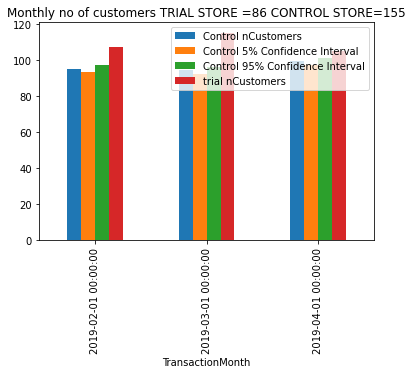

In [67]:
combinenCustomers.iloc[7:10].plot.bar().set_title("Monthly no of customers TRIAL STORE =86 CONTROL STORE=155");

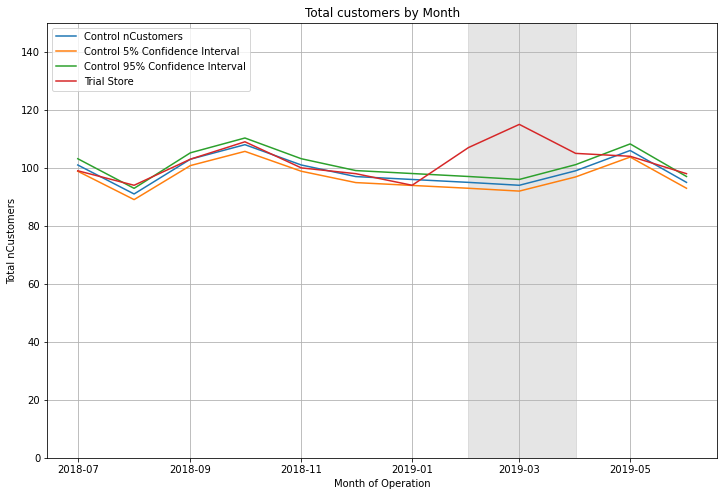

In [68]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combinenCustomers)

# Set graph title and axis title
plt.title('Total customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total nCustomers')

# Set legend
plt.legend(['Control nCustomers', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 150))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()


It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.


## Selecting control store for trial store 88


In [69]:
scaledControlSales = scaleControl(88,237,'TOT_SALES')
scaledControlSales

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaleControlTOT_SALES
2747,237,201807,1448.4,128,1.265625,2.531250,4.470370,1450.657086
2748,237,201808,1367.8,135,1.229630,2.318519,4.369968,1369.931485
2749,237,201809,1322.2,126,1.190476,2.373016,4.422074,1324.260425
2750,237,201810,1348.3,123,1.219512,2.430894,4.509365,1350.401097
2751,237,201811,1397.6,132,1.219697,2.424242,4.367500,1399.777923
2752,237,201812,1265.0,124,1.169355,2.330645,4.377163,1266.971288
2753,237,201901,1219.7,117,1.188034,2.367521,4.403249,1221.600696
2754,237,201902,1404.8,126,1.246032,2.492063,4.473885,1406.989143
2755,237,201903,1208.2,119,1.151261,2.302521,4.409489,1210.082775
2756,237,201904,1204.6,120,1.133333,2.266667,4.428676,1206.477165


In [70]:
# Calculate percentage difference
percentageDiffSales = percentDiff(86,155,'TOT_SALES')
percentageDiffSales

,YEARMONTH,ScaleControlTOT_SALES,trialTOT_SALES,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


In [71]:
percentageDiffSales = calcTvalue(88,237,'TOT_SALES')
percentageDiffSales

,YEARMONTH,ScaleControlTOT_SALES,trialTOT_SALES,percentageDiff,tValue
0,201807,1450.657086,1310.00,0.096961,2.897136
1,201808,1369.931485,1323.80,0.033674,1.006168
2,201809,1324.260425,1423.00,0.074562,2.227870
3,201810,1350.401097,1352.40,0.001480,0.044228
4,201811,1399.777923,1382.80,0.012129,0.362408
5,201812,1266.971288,1325.20,0.045959,1.373227
6,201901,1221.600696,1266.40,0.036673,1.095756
7,201902,1406.989143,1370.20,0.026147,0.781270
8,201903,1210.082775,1477.20,0.220743,6.595668
9,201904,1206.477165,1439.40,0.193060,5.768527


 We can see that the t-value is not much larger than the 95th percentile value of the t-distribution.
 
 Now let's we have reached to a conslusion that accordig to the comparision metric `TOT_SALES` there's and uplift in march and april , wont it be great if we can visualize this thing.
 
 let's make 5% and 95% confidance interval and plot a comparison graph

In [72]:
combineSales = cfInterval(88,237,'TOT_SALES')
combineSales

,Control SALES,Control 5% Confidence Interval,Control 95% Confidence Interval,trial SALES
TransactionMonth,,,,
2018-07-01,1450.657086,1353.556288,1547.757884,1310.00
2018-08-01,1369.931485,1278.234114,1461.628855,1323.80
2018-09-01,1324.260425,1235.620080,1412.900769,1423.00
2018-10-01,1350.401097,1260.011008,1440.791187,1352.40
2018-11-01,1399.777923,1306.082759,1493.473086,1382.80
2018-12-01,1266.971288,1182.165634,1351.776942,1325.20
2019-01-01,1221.600696,1139.831956,1303.369436,1266.40
2019-02-01,1406.989143,1312.811291,1501.166995,1370.20
2019-03-01,1210.082775,1129.084996,1291.080555,1477.20


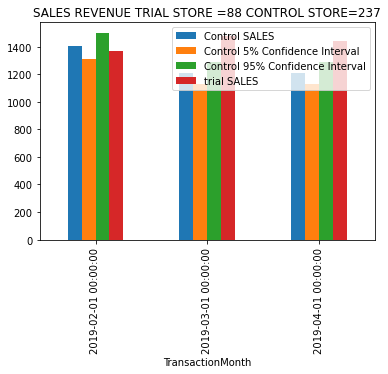

In [73]:
combineSales.iloc[7:10].plot.bar().set_title("SALES REVENUE TRIAL STORE =88 CONTROL STORE=237");

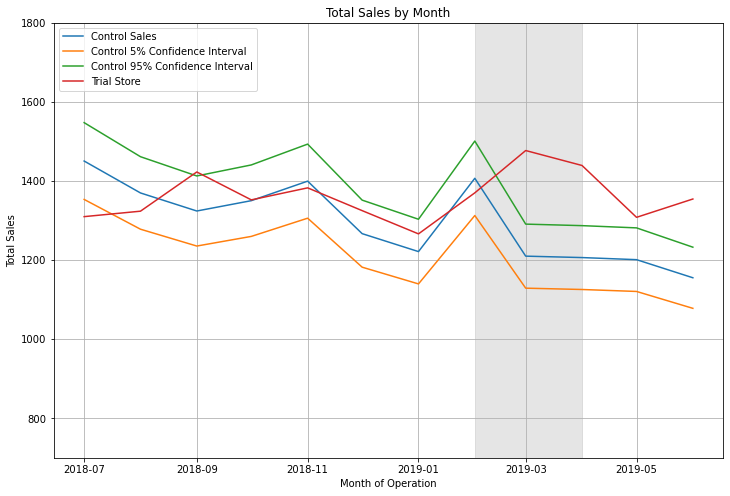

In [74]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((700,1800 ))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

now let's have a look nCustomers

In [75]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'nCustomers' for trial store by sum of 'nCustomers' for control store
# Let's call this variable 'scalingFactornCustomers'
scaledControlnCustomers = scaleControl(88,237,'nCustomers')
scaledControlnCustomers

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,ScaleControlnCustomers
2747,237,201807,1448.4,128,1.265625,2.531250,4.470370,127.276836
2748,237,201808,1367.8,135,1.229630,2.318519,4.369968,134.237288
2749,237,201809,1322.2,126,1.190476,2.373016,4.422074,125.288136
2750,237,201810,1348.3,123,1.219512,2.430894,4.509365,122.305085
2751,237,201811,1397.6,132,1.219697,2.424242,4.367500,131.254237
2752,237,201812,1265.0,124,1.169355,2.330645,4.377163,123.299435
2753,237,201901,1219.7,117,1.188034,2.367521,4.403249,116.338983
2754,237,201902,1404.8,126,1.246032,2.492063,4.473885,125.288136
2755,237,201903,1208.2,119,1.151261,2.302521,4.409489,118.327684
2756,237,201904,1204.6,120,1.133333,2.266667,4.428676,119.322034


In [76]:
# Calculate percentage difference
percentageDiffnCustomers = percentDiff(86,155,'nCustomers')
percentageDiffnCustomers

,YEARMONTH,ScaleControlnCustomers,trialnCustomers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901
5,201812,97.0,98,0.010309
6,201901,96.0,94,0.020833
7,201902,95.0,107,0.126316
8,201903,94.0,115,0.223404
9,201904,99.0,105,0.060606


In [77]:
percentageDiffnCustomers = calcTvalue(88,237,'nCustomers')
percentageDiffnCustomers

,YEARMONTH,ScaleControlnCustomers,trialnCustomers,percentageDiff,tValue
0,201807,127.276836,129,0.013539,1.827026
1,201808,134.237288,131,0.024116,3.254435
2,201809,125.288136,124,0.010281,1.387456
3,201810,122.305085,123,0.005682,0.766752
4,201811,131.254237,130,0.009556,1.289537
5,201812,123.299435,126,0.021902,2.955705
6,201901,116.338983,117,0.005682,0.766752
7,201902,125.288136,124,0.010281,1.387456
8,201903,118.327684,134,0.132448,17.873693
9,201904,119.322034,128,0.072727,9.814423


 We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March.
 
 Now let's we have reached to a conslusion that accordig to the comparision metric `nCustomers	` there's and uplift in march and april , wont it be great if we can visualize this thing.
 
 let's make 5% and 95% confidance interval and plot a comparison graph

In [78]:
combinenCustomers = cfInterval(86,155,'nCustomers')
combinenCustomers

,Control nCustomers,Control 5% Confidence Interval,Control 95% Confidence Interval,trial nCustomers
TransactionMonth,,,,
2018-07-01,101.0,98.841136,103.158864,99
2018-08-01,91.0,89.054885,92.945115,94
2018-09-01,103.0,100.798386,105.201614,103
2018-10-01,108.0,105.691512,110.308488,109
2018-11-01,101.0,98.841136,103.158864,100
2018-12-01,97.0,94.926636,99.073364,98
2019-01-01,96.0,93.948011,98.051989,94
2019-02-01,95.0,92.969386,97.030614,107
2019-03-01,94.0,91.990760,96.009240,115


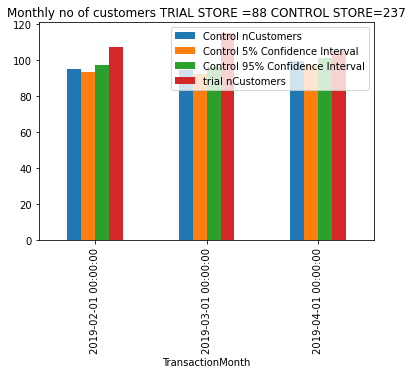

In [79]:
combinenCustomers.iloc[7:10].plot.bar().set_title("Monthly no of customers TRIAL STORE =88 CONTROL STORE=237");

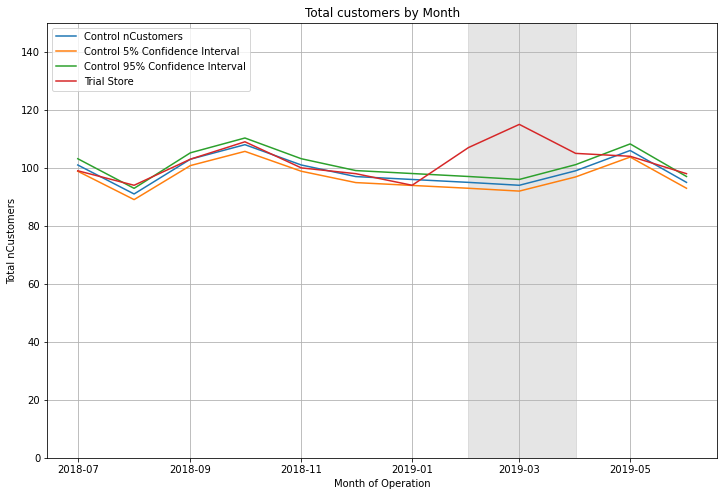

In [80]:
# Let's embellish the plot

# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combinenCustomers)

# Set graph title and axis title
plt.title('Total customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total nCustomers')

# Set legend
plt.legend(['Control nCustomers', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 150))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()


Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively. The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.